# EVCSAP Stochastic Programming - $\phi^{IJ}$ validation Test
*Author: Gen LI; Date: 14.11.22*


In [3]:
# Import local scripts
 
# import src.c.d

import os, sys
currentdir = os.path.dirname(os.path.realpath(''))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

from csap_packages_sp import sp_data_process as Dap
# from csap_packages_sp import sp_model_setup as Sup
from csap_packages_sp import sp_model_setup_by_fm_data as SupSP
from csap_packages_sp import sp_stat_compu as Stac
from csap_packages_sp import sp_sce_generation as Sceg
from csap_packages_sp.sp_mpd_frame_model_setup import _build_mpdp_csap_frame


# Import Opensource packages
import idaes
import numpy as np
import pandas as pd
import geopandas as gpd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyproj import CRS
from shapely.geometry import Point, MultiPoint
import matplotlib.pyplot as plt
from tqdm import tqdm
from cProfile import label
import plotly.express as px
from pyomo.core.expr.current import evaluate_expression
import time
import pickle
import seaborn
from mpisppy.opt.ef import ExtensiveForm

# seaborn.set_theme(context = 'notebook', style = 'whitegrid')

# np.random.seed(121022)
# currentdir, parentdir

[    0.00] Initializing mpi-sppy


In [7]:
currentdir, parentdir

('C:\\Users\\z004ffpm\\Work_Documents\\CSallocModel\\model_evcsap\\stochastic_model\\Validation_02_Dec',
 'C:\\Users\\z004ffpm\\Work_Documents\\CSallocModel\\model_evcsap\\stochastic_model')

## Section 1: Pre-process Geo-data to get Setup Dictionary for pyomo model

In [167]:
#########################################################
#### Load Data from OSM, Sythetic, OCM, DE Bundesamt #### 

# --- Load Schutter Wald OSM Data (Resource from hdgb API by Domenico) --- # 
geojson_folder = r"C:\Users\z004ffpm\Work_Documents\MyExtractedData\hdgb\77746\geojson"
geojson_filename = r"\evcsap_77746_ss.geojson"
filepath = geojson_folder + geojson_filename
SW_gdf = gpd.read_file(filepath)

# --- Load Synthetic Substations Data for SW (Resource from Domenico) --- #
path_synthetic_ss_SW =  r"C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\Data\SW_transformers.csv"
df = pd.read_csv(path_synthetic_ss_SW)
df['element'] = 'substations' # We keep the 'tag' == 'transformers', for later reference that these data are synthetic
syn_ss_SW_gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.lon, df.lat)
)

# --- Load existing old CSs from OCM --- #
# # There's no CS data for Schutterwald on OCM, thus jump this step. (Resouce from Sisi)
# df_ocm = pd.read_csv('./ocm.csv')

# --- Load existing old CSs from "Ladesaeulenregistered" by DE Bundesamt --- #
df_DE_Gov = pd.read_csv(
    r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\Ladesaeulenregister_CSV.csv', 
    encoding = "ISO-8859-1", # "utf-8", 
    header = 10, 
    sep = ';'
    )
# df_DE_Gov.head(3)
oldCS_df_SW = df_DE_Gov[df_DE_Gov.Postleitzahl == 77746] # EDEKA Oberle Getränkemarkt

#########################################################################################
#### Process loaded data, define single-period and multi-period deterministic data ######

# --- concat OSM and Synthetic data for SW --- #
SW_concat_gdf = gpd.GeoDataFrame(pd.concat([SW_gdf, syn_ss_SW_gdf], axis=0, ignore_index=True))

# --- Pre-process concatted data --- #
gdfcopy = SW_concat_gdf.copy()

# Calculate centroids by merging data with same id. 
gdfcopy = Dap._get_centered_gdf(gdfcopy)

# # Get parking and charging_station info from `df['tag']` to define candidate locations for new CSs
gdfcopy = Dap._detect_parking_CS_SS(gdfcopy)

# --- Insert Bundesnetzagentur data to concatted DataFrame --- #
lat_sw = float(oldCS_df_SW.loc[4012, 'Breitengrad'].replace(',', '.'))
lon_sw = float(oldCS_df_SW.loc[4012, 'Längengrad'].replace(',', '.'))
geo_array = np.array([lon_sw, lat_sw])
gdfcopy.loc[len(gdfcopy)] = {
    'osm_id': 'regisID_4012',
    'element': 'charging_station',
    'tag': "{'amenity': 'charging_station', \
            'Source': 'Bundesnetzagentur'}",
    'geometry': Point(lon_sw,lat_sw),
    'lat': lat_sw,
    'lon': lon_sw,
    'id_count': 1,
    'parking_capacity': None,
    'max_extraCPsToInstall': 2,
    'charging_capacity': 2,
    } # Useful Reference: https://gis.stackexchange.com/questions/345167/building-geodataframe-row-by-row




# # Identify indicies for different nodes
# id_candi_locs2update = gdfcopy[gdfcopy['element'] == 'charging_station'].index
# id_candi_locs2buildNew = gdfcopy[gdfcopy['element'] == 'parking'].index
# id_candi_locs_total = id_candi_locs2update.union(id_candi_locs2buildNew)

# id_substations = gdfcopy[gdfcopy['element'] == 'substations'].index

# id_cd_centers = gdfcopy.loc[(gdfcopy['element'] != 'parking') \
#         & (gdfcopy['element'] != 'charging_station') \
#             & (gdfcopy['element'] != 'substations')
#         , :].index
# id_CS_SS = gdfcopy.loc[(gdfcopy['element'] == 'parking') \
#         | (gdfcopy['element'] == 'charging_station') \
#             | (gdfcopy['element'] == 'substations')
#         , :].index


# --- Build multi-period POI statistics Dataframe  --- # 
### Define statistics by sampling from Poisson/Beta/Normal distributions. 
### These data are treated as known info to EVCSAP model 
dict_POI_Statistics = {
    'normal':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 80, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (25/60, 5/60)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 20, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (15/60, 3/60)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 60, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (45/60, 6/60)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 130, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (35/60, 6/60)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 60, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (60/60, 9/60)
            }
    },
    'peak':{
        'amenity': {
            'NrArrival_poissonDistr_lam': 24, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (25/60, 6/60)
        },
        'historic': {
            'NrArrival_poissonDistr_lam': 7, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (25, 3),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (15/60, 3/60)
        },
        'leisure': {
            'NrArrival_poissonDistr_lam': 15, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (45/60, 6/60)
        },
        'shop': {
            'NrArrival_poissonDistr_lam': 40, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (22, 2),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (35/60, 6/60)
        },
        'sport': {
            'NrArrival_poissonDistr_lam': 20, # For poisson distribution, mean = lambda
            'Arrival_SOC_betaDistr_(alpha,beta)': (21, 4),  # For beta distribution, mean = alpha/(alpha+beta)
            'Visiting_duration_normalDistr_(loc,scale)': (60/60, 9/60)
        }
    }     
}
### Build POIs stat df
df_SW_POI_stat_mpd = Dap._assign_mp_POI_statistics(
    gdf = gdfcopy, dict_POI_Statistics = dict_POI_Statistics
)


# --- Build multi-period Substations Statistics Dataframe --- # 
### Define statistics by sampling from normal distributions. 
### These data are treated as known info to EVCSAP model 
avg_SS_full_load_cap = 400
dict_mpd_SW_SS_Statistics = { # The only substation statistics to define is the available power load (on avg.) during different periods 
    'normal': (0.2*avg_SS_full_load_cap, 0), # means the available power load follows a normal distribution with (mean = 80, std = 0)
    'peak': (0.12*avg_SS_full_load_cap, 0)
}
### Build SSs stat df
df_SW_SS_stat_mpd = Dap._assign_mp_SS_statistics(
    gdf = gdfcopy, dict_mpd_SS_Statistics = dict_mpd_SW_SS_Statistics
)



Extracting parking info from gdf["tag"]: 100%|█████████████████████████████████████| 195/195 [00:00<00:00, 7498.55it/s]
C:\Users\z004ffpm\Anaconda3\envs\OptPyomoSP\lib\site-packages\pandas\core\construction.py:762: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

Assigning SS statistics: 100%|██████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 333.44it/s]


In [168]:
#########################################################
####      Get Model Setup Strategy dictionary      ######
# Define Strategy dictionary for other non-osm/ocm/synthetic... parameters
strategy_dict = {
    # ----- CS ----- #
    'cost_buildNewCS': 3000, # float, annuity of updating an old opened CS
    'cost_updateOldCS': 2500, # float, annuity of updating an old opened CS
    'cost_installCP': 2250, # float, annuity of installing a CP

    'profit_charge_fee': (0.3, 0.00), # set as normal Distrib. (mean, std), charging fee at CS euro/kWh
    'budget_max_N_newBuildCS' : 10, # int, max amount of new CSs the investors want to open
    'budget_max_N_updateCS' : 1, # int, max amount of old CSs investors want to update
    'budget_max_N_totalCSs' : 9, # int, max amount of CSs (old or new) to update or open in total:
    'budget_max_N_new_CPs' : 115, # int, max amount of new CPs investors want to install
    'rule_Min_dist_Between_CSs' : 2/60, # float in hour, min distance allowed between two CSs
    'config_CPpower' : 22, # float, in kW, Power rating of a CP,
    
    # ----- SS ----- #
    'cost_expandSS': 500, # float, annuity of substation powerload expansion per KW.     
        # Since domain of grid decision variables can be: [0, 100, 200,...], 
        # every expansion cost then can be in the unit of €/100kW
    'cost_backstopTech': 5, # float, one time cost of using backstop tech per KW to prevent overload blackout
        # This is one time cost, and domain of backstop tech usage decision variables is: [0, 100, 200,...], 
        # which means every usage of backstop tech is in the unit of (365 * €/100kW ) 
    ## ---- Stochastic scenario generation ---- ##
    'max_dist_cs_ss_connection': 6/60, # float in hour, walking distance (5km/hour) -> 6/60 * 5000 = 500 m        
    'CS_neighbour_dist_decay_threshold': 4/60, # float in hour, walking distance (5km/hour) 
        # # used for calculating dist_decay between CSs to adjust "neighbours' connection reward weights"
        # # 'CS_neighbour_dist_decay_threshold' > 'rule_Min_dist_Between_CSs'
    
    # ----- CD ----- #    
    'rule_dist_decay_threshold' : 5/60, # float in hour, max walking dist EV drivers can tolerate to charge their EVs    
    'config_Battery_cap': 44, # float, in kWh, battery capacities of EVs
    'config_periods_length': {'normal': 22, 'peak': 2},        
}

# Get setup dictionary for auxilliary model 
csap_setup_dict_4_auxi, gdf_4_auxi = Dap._get_ModelSetupDict(
    gdf = gdfcopy, 
    strategy_dict = strategy_dict,    
    mpd_poi_stats_df = df_SW_POI_stat_mpd,
    mpd_SS_stats_df = df_SW_SS_stat_mpd
)

# Set up auxilliary model 
# and get (gdf, substations_stat_df) after droping isolated nodes
auxi_model_2_drop_islt_nodes = Sceg.get_auxi_model(
    setup_dict = csap_setup_dict_4_auxi
    )

gdfcopy_dropped_isolated, df_SW_SS_stat_mpd_dropped_isolated = \
    Dap._get_dfs_with_isolated_nodes_dropped(
        auxilliary_model = auxi_model_2_drop_islt_nodes, 
        origin_gdf = gdfcopy, 
        origin_SS_stat_df = df_SW_SS_stat_mpd
    )

# Get the formal Set-up dictionary for generating scenarios and set-up model
csap_setup_dict, final_gdf = Dap._get_ModelSetupDict(
    gdf = gdfcopy_dropped_isolated, 
    strategy_dict = strategy_dict,    
    mpd_poi_stats_df = df_SW_POI_stat_mpd,
    mpd_SS_stats_df = df_SW_SS_stat_mpd_dropped_isolated
)


# import pickle 
with open('0412_sces500_convergence_test_setup_dict.pickle', 'wb') as f:
    pickle.dump(csap_setup_dict, f)
# 
# csap_setup_dict = pd.read_pickle('dict_mpsp_setup_vali_23Nov.pickle')

Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 
Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.25 seconds.
Created 
Created a setup dictionary for pyomo auxi/frame/formal models and a processed regional geodataframe 


In [1]:
save_fig = False
Dap.geo_visualizer(final_gdf, save_fig) 

NameError: name 'Dap' is not defined

In [54]:
# with open('0412__convergence_another_test_setup_dict.pickle', 'wb') as f:
#     pickle.dump(csap_setup_dict, f)

## Section 2: Generate Random Scenarios for CS-SS Connection

In [4]:
# copy_csap_setup_dict = csap_setup_dict.copy() 
csap_setup_dict = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_2_phi_IJ_walk_dist_2_charge\0412_wastedESC_test_setup_dict.pickle')
mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')

In [171]:
###############################################################
####    Generate stochstic cs-ss connection scenarios    ######
cs_ss_con_sce_auxi_model = Sceg.get_auxi_model(
    setup_dict = csap_setup_dict
    )
# all_connection_sces_dict, all_connect_prob_dict = Sceg._generate_cs_ss_connection_sces(
# all_connection_sces_dict = Sceg._generate_cs_ss_connection_sces(
#     num_scenarios = 20000,
#     auxi_model = cs_ss_con_sce_auxi_model,
#     save_prob_matrices = False #True
#     )
# Save generated connection scenarios
# import pickle 
# with open('20k_con_sces_dropped_isl.pickle', 'wb') as f:
#     pickle.dump(all_connection_sces_dict, f)
# with open('20k_con_probs_dropped_isl.pickle', 'wb') as f:
#     pickle.dump(all_connect_prob_dict, f)


Set up an auxilliary model and calculate distances and distance decay factors between CSs and SSs to either deal with isolated nodes or generate connection scenarios for stochastic EVCSAP
Done! Process took 0.15 seconds.


In [ ]:
# generated_scenarios = pd.read_pickle('20k_con_sces_dropped_isl.pickle')

# total_connection_matrixm, mpdp_connection_sce = \
#     Sceg._get_total_con_matrix_and_mpdp_con_sce(
#         generated_connections = generated_scenarios
#     )
# Sceg._get_total_num_sces(total_connection_matrixm)

In [2]:
mpdp_connection_dict = {'mpdp_connection': mpdp_connection_sce}
Sceg._plot_cs_ss_connection_graph(
        cs_ss_con_sce_auxi_model, 
        mpdp_connection_dict, 'mpdp_connection'
        )

NameError: name 'mpdp_connection_sce' is not defined

## Section 3: Setup and Solve Multi-Period Stochastic model
### Setup Frame Model

In [6]:
model_name = 'mpdp_frame_model_4_sp' # assign name to pyomo model, default name set in the setup function is 'CSAP'
csap_is_solved = False
linearize_csap = True
# sce_id = '1'
# connection_sce = all_connection_sces_dict[sce_id].stack().to_dict()

mpdp_frame_model_4_sp = _build_mpdp_csap_frame(    
    setup_dict = csap_setup_dict, 
    cs_ss_connect_sce = mpdp_connection_sce.stack().to_dict(),
    m_name = model_name, 
    linearized = linearize_csap
)

Built an empty concrete pyomo model named mpdp_frame_model_4_sp. 
Defining sets   ...
Parameters_setup 1: Feeding basic parameters to mpdp_frame_model_4_sp ...
Parameters_setup 2: Feeding CS parameters  to 'mpdp_frame_model_4_sp' ...
Parameters_setup 3: Feeding SS parameters to 'mpdp_frame_model_4_sp' ... 
Parameters_setup 4: Feeding CD parameters to mpdp_frame_model_4_sp ... 
 ... 
   Calculating walking distances between candidate locations and CD centers: model.d ...
     Done! Process took 0.64 seconds.
All CD parameters fed! 

Feeding cs-ss connection scenario to model ... 
Feeding decision variables ... 
Defining Expression of Exogenous (Charging) Energy Supply Capability of CSs ...
 Done! Process took 34.44 seconds.
Feeding objective to mpdp_frame_model_4_sp ...

          There are two objectives 'obj_total_cost' and 'obj_cost_no_grid' in frame model.
          Before resolution, use method:
    `model.objective_name.deactive()` to deactive one of them and solve the model with 

### Solve Frame Model

0

In [14]:
# Objective with grid and 
# loose grid load constraints based on (efficient) energy CPs requested
mpdp_frame_model_4_sp.obj_cost_no_grid.deactivate()
mpdp_frame_model_4_sp.obj_total_cost.activate()
mpdp_frame_model_4_sp.cons_grid_load_efficientCD.activate()
mpdp_frame_model_4_sp.cons_grid_load_NrCPs.deactivate()
# csap_LP.cons_CDcoverageLB.activate()

Solver = SolverFactory(
#     'glpk'
#     'ipopt'
    'cplex'
#     'gams'
#     'cplex_direct'
#     'bonmin'
    # 'couenne'
    , tee = True, 
)

mpdp_frame_model_4_sp.n[195].value = 2

results_with_old_CS = Solver.solve(mpdp_frame_model_4_sp)
csap_is_solved = True
print("Results with old CSs\n", results_with_old_CS)
print_decision = True
if print_decision:
    Stac._print_decision(mpdp_frame_model_4_sp)
#     _print_decision(mpdp_frame_model_4_sp)


mpdp_frame_model_4_sp.n[195].value = 0
results_NO_old_CS = Solver.solve(mpdp_frame_model_4_sp)
csap_is_solved = True
print("Results NO old CSs\n", results_NO_old_CS)
print_decision = True
if print_decision:
    Stac._print_decision(mpdp_frame_model_4_sp)


# Dap._plot_model_graph(
#     model = mpdp_frame_model_4_sp, 
#     cd_period = 'peak',
#     model_is_solved = csap_is_solved
# )


Results with LB
 
Problem: 
- Name: tmpnwqez0na
  Lower bound: -1548831.2038046352
  Upper bound: -1548831.2038046352
  Number of objectives: 1
  Number of constraints: 2475
  Number of variables: 4615
  Number of nonzeros: 9652
  Sense: minimize
Solver: 
- Status: ok
  User time: 0.09
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = -1.5488312038e+06
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.2111949920654297
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Decision to build new CSs, 
(loc_id, Nr_CP): 
[(36, 2.0), (48, 10.0), (58, 8.0), (61, 8.0), (96, 8.0), (110, 8.0), (115, 12.0), (178, 26.0)]

Decision to update old CSs, 
(loc_id, Nr_CP, Nr_total_CPs): 
[(195, 2.0, 4.0)]
Decision to expand SSs, 
(loc_id, size_expansion): 
[(6, 150.0), (8, 300.0), (10, 50.0), (74, 50.0)]

Decision to use expensive backstop tech 

In [3]:
Dap._plot_model_graph(
    model = mpdp_frame_model_4_sp, 
    cd_period = 'normal',
    model_is_solved = csap_is_solved
)

NameError: name 'Dap' is not defined

### Method to Solution Results and Frame_Model_Data in One Dictionary

In [176]:
test_result_dict = Stac._get_data_from_solved_mpdp(
# test_result_dict = _get_data_from_solved_mpdp(
    solver_results = results_withLB,
    solved_model = mpdp_frame_model_4_sp,    
    )
hourly_CD_cover_each_CP_at_CSs, Nr_CPs = \
        Stac._get_hourly_CD_cover_each_CP_atCSs(mpdp_frame_model_4_sp)
wastedESC_dict = Stac._get_total_wastedESC_by_parking(mpdp_frame_model_4_sp)
daily_regional_CD_dict = Stac._get_total_regional_CD(mpdp_frame_model_4_sp)

In [177]:
Nr_CPs

36               2
48              10
58               8
61               7
96               8
110              7
115             12
178             26
195              4
region_total    84
dtype: int64

# Extremly weird wastedESC at 195, which can be >22 kWh/hour?

In [180]:
psi_dict = {key:pyo.value(val) for key, val in mpdp_frame_model_4_sp.psi.extract_values().items()}
psi_df = pd.Series(psi_dict).unstack()
psi_df['Nr_CPs'] = Nr_CPs

In [181]:
w_dict = {key:pyo.value(val) for key, val in mpdp_frame_model_4_sp.w.extract_values().items()}
w_df = pd.Series(w_dict).unstack()
w_df['Nr_CPs'] = Nr_CPs

In [182]:
w_df

,normal,peak,Nr_CPs
18,0.000000,0.000000,NaN
36,358.117384,32.920375,2.0
48,2966.489341,262.260505,10.0
58,1869.731363,153.458507,8.0
61,2234.818558,164.684014,7.0
96,2277.476133,188.150685,8.0
110,1993.924919,153.185902,7.0
114,0.000000,0.000000,NaN
115,3192.519860,241.611678,12.0
177,0.000000,0.000000,NaN


In [183]:
psi_df

,normal,peak,Nr_CPs
18,0.000000e+00,0.000000,NaN
36,3.173202e+02,28.935053,2.0
48,2.925419e+03,260.244870,10.0
58,1.860007e+03,148.445159,8.0
61,2.146137e+03,151.686540,7.0
96,1.732373e+03,135.755130,8.0
110,1.355055e+03,120.319301,7.0
114,-7.453791e-12,0.000000,NaN
115,3.132876e+03,236.495943,12.0
177,0.000000e+00,0.000000,NaN


In [184]:
wastedESC_dict

,normal,peak
18,0.000000e+00,0.000000
36,5.517291e+02,48.812113
48,1.912624e+03,187.036582
58,1.470355e+03,255.034347
61,5.689043e+02,119.071208
96,1.041772e+03,81.221031
110,1.325118e+03,140.076042
114,-2.931955e-12,0.000000
115,2.185710e+03,172.276323
177,0.000000e+00,0.000000


In [185]:
w_df['TESC_normal'] = Nr_CPs*22*22
w_df['TESC_peak'] = Nr_CPs*22*2

In [187]:
pd.concat([w_df, psi_df, wastedESC_dict], axis = 1).divide(Nr_CPs, axis = 0)

,normal,peak,Nr_CPs,TESC_normal,TESC_peak,normal,peak,Nr_CPs,normal,peak
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,179.058692,16.460188,1.0,484.0,44.0,158.660076,14.467526,1.0,275.864547,24.406056
48,296.648934,26.226050,1.0,484.0,44.0,292.541925,26.024487,1.0,191.262444,18.703658
58,233.716420,19.182313,1.0,484.0,44.0,232.500936,18.555645,1.0,183.794421,31.879293
61,319.259794,23.526288,1.0,484.0,44.0,306.591058,21.669506,1.0,81.272050,17.010173
96,284.684517,23.518836,1.0,484.0,44.0,216.546676,16.969391,1.0,130.221542,10.152629
110,284.846417,21.883700,1.0,484.0,44.0,193.579250,17.188472,1.0,189.302521,20.010863
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,266.043322,20.134307,1.0,484.0,44.0,261.072967,19.707995,1.0,182.142520,14.356360
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
wastedESC_dict#.divide(Nr_CPs, axis = 0)/np.array([22,2])

,normal,peak
18,0.000000,0.000000
36,516.095171,56.028535
48,1944.737456,165.340374
58,2713.673981,59.280321
61,1174.989861,105.893623
96,857.964427,104.950117
110,1014.946369,106.245021
114,2768.573052,193.185698
115,1519.929706,256.569496
177,0.000000,0.000000


In [61]:
hourly_CD_cover_each_CP_at_CSs

,normal,peak
36,7.986727,5.714913
48,14.027979,12.456360
58,9.462292,8.661968
61,11.801558,9.248745
96,9.760525,9.179550
110,8.786773,8.720717
114,4.938573,9.907458
115,11.378732,11.546170
178,7.105194,6.433422
195,10.663542,8.080131


In [62]:
# pyo.value(mpdp_frame_model_4_sp.calT[159, 'normal'])
pyo.value(mpdp_frame_model_4_sp.pi * (mpdp_frame_model_4_sp.calT[159, 'normal']+2*mpdp_frame_model_4_sp.d[195,159]))
pyo.value((1-mpdp_frame_model_4_sp.delta[159,'normal'])*44)

7.177603887561876

In [103]:
mpdp_frame_model_4_sp.calD[195,159,'normal'].pprint()

{Member of calD} : CD of a single arrival at CS i ∈ I raised by a visiting to POI j ∈ J during t ∈ T.
    Size=3792, Index=calD_index
    Key                  : Expression
    (195, 159, 'normal') : 9.892481976498548


In [79]:
for j in mpdp_frame_model_4_sp.J:
    for t in mpdp_frame_model_4_sp.T:
        char_val = pyo.value(mpdp_frame_model_4_sp.z[195,j,t])
        if char_val > 1e-5:
            print(f'{j},{t}: {char_val}')

27,peak: 0.09587206869332798
29,peak: 0.059884514813804864
84,normal: 0.5047446530012649
176,peak: 0.09165242609897638
182,peak: 0.07129587343422471
189,normal: 0.9179808216985322


In [86]:
pyo.value(mpdp_frame_model_4_sp.calD[195, 84, 'normal']), pyo.value(mpdp_frame_model_4_sp.calD[195, 189, 'normal'])

(8.547914001004461, 0.4241127012028958)

In [108]:
(pyo.value(mpdp_frame_model_4_sp.calT[84, 'normal'])*22, pyo.value(mpdp_frame_model_4_sp.calT[189, 'normal'])*22)

(14.07865535794443, 11.285716274915167)

In [105]:
pyo.value(mpdp_frame_model_4_sp.calA[84, 'normal']), pyo.value(mpdp_frame_model_4_sp.calA[189, 'normal'])

(99.0, 116.0)

In [130]:
import plotly.express as px
# from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_phi_IJ_total_hourlyCD_Cover(
    df_1CP_CD_cov: pd.DataFrame,
    df_Nr_CPs: pd.DataFrame,
    plot_type: str = 'histo',
    plot_name: str = 'Name of Graph'
    ):
    df_1CP_CD_cov_copy = df_1CP_CD_cov.copy()
    columns = df_1CP_CD_cov_copy.columns
#     df_copy['sum'] = df_copy.sum(axis=1)
    # wide_df['phi_II'] = [4/60, 5/60,7/60]
    plot_labels = {
        'x': 'Grid Period', 
        'y': 'Connections'
#         **{str(col): f"CS {col}" for col in columns}, #'Number of CS-SS Connections',
#         
    }
    
    if plot_type == 'histo':
        fig = px.histogram(
            df_1CP_CD_cov_copy, x=df_1CP_CD_cov_copy.index.astype(str), 
            y=columns, 
#             facet_col = columns,
#             title=plot_name, 
#             text_auto = True,
            barmode = 'relative', #str (default `'relative'`) 'group', 'overlay' or 'relative'
            orientation = 'v',
            cumulative = False,
            labels = plot_labels
            # marginal = "histogram",
            # marginal_y = "violin",
            # opacity = 0.7,                       
        )
#     print(plot_labels)

#         trace_cols_of_interest = ['sum']
#         for col in cols_of_interest:
        fig.add_trace(
             go.Scatter(
        #          wide_df,
                x=df_1CP_CD_cov.index, 
                y=df_1CP_CD_cov.sum(axis = 1), 
#                 mode="lines",
#                 line=go.scatter.Line(
#                  color="gray"
#              ),
                showlegend=True,
#                  opacity = 0.7,
                 name = f'Sum',
             )
        )


    fig.update_layout(legend=dict(
        orientation="v",
        yanchor="auto",
        y=1.00,
        xanchor="auto",
        x=1.15
        ),
        plot_bgcolor = 'rgba(0,0,0,0.05)',
      legend_title_text='CS ID (Nr. CPs)',
          title={
        'text': plot_name,
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
     )
    fig.show()


### Test for phi_IJ in [0,8] (TODO by 05.Dec)

In [21]:
str_phi_IJ_list = [f'{i}/60' for i in range(1,2)]
float_phi_IJ_list = [i/60 for i in range(1,2)]
test_result_dict = dict()

for idx, phi_IJ in enumerate(str_phi_IJ_list):
    print('---------------------------')

    copy_csap_setup_dict['params_cd']['phi_IJ'] = float_phi_IJ_list[idx]
    model_name = 'mpdp_frame_model_4_sp' # assign name to pyomo model, default name set in the setup function is 'CSAP'
    csap_is_solved = False
    linearize_csap = True

    mpdp_frame_model_4_sp = _build_mpdp_csap_frame(    
        setup_dict = csap_setup_dict, 
        cs_ss_connect_sce = mpdp_connection_sce.stack().to_dict(),
        m_name = model_name, 
        linearized = linearize_csap
    )
    mpdp_frame_model_4_sp.obj_cost_no_grid.deactivate()
    mpdp_frame_model_4_sp.obj_total_cost.activate()
    mpdp_frame_model_4_sp.cons_grid_load_efficientCD.activate()
    mpdp_frame_model_4_sp.cons_grid_load_NrCPs.deactivate()
    
    test_results = Solver.solve(mpdp_frame_model_4_sp)
    csap_is_solved = True    
        ## Store results in the dict
    print("Storing test results ... ")
    results_prob_descrip = test_results['Problem'][0]
    results_solver_info = test_results['Solver'][0]
#     current_obj_val = test_results['Solution'][0]['Objective']['__default_objective__']['Value']

    model_data = SupSP._get_data_from_frame_model(frame_model = mpdp_frame_model_4_sp)
    ## Store CSAP decisions

    test_result_dict[idx] = {
        'num_scenarios': num_sces,
        'ids_scenarios': selected_sces_names,
        'objective_value' : current_obj_val,
        'prob_description': {key: results_prob_descrip[key] for key in useful_description_info_list },
        'solver_info' : {key: results_solver_info[key] for key in useful_solver_info_list},
        'gap' : results['Solution'][0]['Gap'], 
        'one_subsceModel_data' : model_data
        # 'mpsp_csap_decisions': mpsp_decisions 
    }
    print('Done\n---------------------------------------\n')
    
    
    
    print(f"Results of phi_IJ = {phi_IJ} is: {results_solver_info['Termination message']}")
    # print(f"Results for \n", test_results)
    print_decision = True
    if print_decision:
        Stac._print_decision(mpdp_frame_model_4_sp)
        
    print('---------------------------')    
    
    hourly_CD_cover_each_CP_at_CSs, Nr_CPs = \
        _get_hourly_CD_cover_each_CP_atCSs(mpdp_frame_model_4_sp)    

---------------------------
Built an empty concrete pyomo model named mpdp_frame_model_4_sp. 
Defining sets   ...
 ...
Parameters_setup 1: Feeding basic parameters to mpdp_frame_model_4_sp ...
 ...
Parameters_setup 2: Feeding parameters   CS to 'mpdp_frame_model_4_sp' ... 
 ... 
 Except for Efficient Charging Energy Capacity of CSs (which need 
              CD parameters and Decision Variables), all CS parameters fed! 

Parameters_setup 3: Feeding SS parameters to 'mpdp_frame_model_4_sp' ... 
 ... 
Parameters_setup 4: Feeding CD parameters to mpdp_frame_model_4_sp ... 
 ... 
     Feeding POI Statistics ...
   Calculating walking distances between candidate locations and CD centers: model.d ...
     Done! Process took 1.77 seconds.
   Calculating dist_decay_factor: model.tau ...
     Done! Process took 0.12 seconds.
    Calculating charging demand of a single arrival CS i ∈ I raised by a visiting to POI j ∈ J during T ... 
    Done! Process took 0.27 seconds.
All CD parameters fed! 

F

NameError: name 'num_sces' is not defined

In [51]:

Solver = SolverFactory(
#     'glpk'
#     'ipopt'
    'cplex'
#     'gams'
#     'cplex_direct'
#     'bonmin'
    # 'couenne'
    , tee = True, 
)

for eta_value in np.arange(1.35, 1.55, 0.07):
    print('---------------------------')
    mpdp_test_m.c_eta = eta_value
    test_results = Solver.solve(mpdp_test_m)
    csap_is_solved = True
    opt_val_message = test_results['Solver'][0]['Termination message']
    print(f"Results of c_eta = {eta_value} is: {opt_val_message}")
    # print(f"Results for \n", test_results)
    print_decision = True
    if print_decision:
        Stac._print_decision(mpdp_test_m)
    print('---------------------------')
    
# Dap._plot_model_graph(
#     model = mpdp_test_m, 
#     cd_period = 'normal',
#     model_is_solved = csap_is_solved
# )


---------------------------
Results of c_eta = 1.35 is: MIP - Integer optimal, tolerance (0.0001/1e-06)\x3a Objective = -1.7304342244e+06
Decision to build new CSs, 
(loc_id, Nr_CP): 
[(48, 10.0), (58, 8.0), (61, 8.0), (96, 8.0), (110, 8.0), (114, 7.0), (115, 12.0), (178, 26.0)]

Decision to update old CSs, 
(loc_id, Nr_CP, Nr_total_CPs): 
[(195, 2.0, 4.0)]
Decision to expand SSs, 
(loc_id, size_expansion): 
[]

Decision to use expensive backstop tech at SSs, 
((loc_id, period), amount_backstop usage): 
[((6, 'peak'), 119.0), ((8, 'peak'), 185.0), ((10, 'peak'), 46.0), ((13, 'peak'), 24.0), ((74, 'peak'), 118.0)]

---------------------------
---------------------------
Results of c_eta = 1.4200000000000002 is: MIP - Integer optimal, tolerance (0.0001/1e-06)\x3a Objective = -1.7268672244e+06
Decision to build new CSs, 
(loc_id, Nr_CP): 
[(48, 10.0), (58, 8.0), (61, 8.0), (96, 8.0), (110, 8.0), (114, 7.0), (115, 12.0), (178, 26.0)]

Decision to update old CSs, 
(loc_id, Nr_CP, Nr_total_C

In [31]:
# with open('dict_mpsp_convergency_test_24Nov_abs5test.pickle', 'wb') as f:
#     pickle.dump(dict_mpsp_c_test_abs5, f)        

dict_mpsp_c_test_abs5

{1: {'num_scenarios': 1,
  'ids_scenarios': array(['3353'], dtype='<U5'),
  'objective_value': -1767717.1501209545,
  'prob_description': {'Lower bound': -1767717.1501209545,
   'Upper bound': -1767717.1501209545,
   'Number of constraints': 3167,
   'Number of variables': 6706},
  'solver_info': {'User time': 0.28,
   'Termination message': 'MIP - Integer optimal solution\\x3a Objective = -1.7677171501e+06',
   'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}},
   'Time': 0.568152904510498},
  'gap': 0.0,
  'mpsp_csap_decisions': {}},
 2: {'num_scenarios': 21,
  'ids_scenarios': array(['5112', '7865', '4334', '3618', '7218', '5238', '9605', '2601',
         '8508', '2205', '2983', '2732', '4271', '2466', '5217', '1640',
         '5009', '5256', '7952', '13', '4904'], dtype='<U5'),
  'objective_value': -1199581.2114090582,
  'prob_description': {'Lower bound': -1199617.8776,
   'Upper bound': -1199581.2114090582,
   'Number of 

In [ ]:
        ## Store results in the dict
        print("Storing test results ... ")
        results_prob_descrip = results['Problem'][0]
        results_solver_info = results['Solver'][0]
        current_obj_val = results['Solution'][0]['Objective']['__default_objective__']['Value']
        
        if SP == True:
            csap_subsces = csap_ef.scenarios()
            subsce_name, subscemodel = next(csap_subsce)
            SP_one_subscemodel_data = SupSP._get_data_from_frame_model(frame_model = subscemodel)
        else:
            model_data = SupSP._get_data_from_frame_model(frame_model = model)
        ## Store CSAP decisions

        test_result_dict[test_id] = {
            'num_scenarios': num_sces,
            'ids_scenarios': selected_sces_names,
            'objective_value' : current_obj_val,
            'prob_description': {key: results_prob_descrip[key] for key in useful_description_info_list },
            'solver_info' : {key: results_solver_info[key] for key in useful_solver_info_list},
            'gap' : results['Solution'][0]['Gap'], 
            'one_subsceModel_data' : SP_one_subscemodel_data
            # 'mpsp_csap_decisions': mpsp_decisions 
        }
        print('Done\n---------------------------------------\n')

In [3]:
# copy_csap_setup_dict = csap_setup_dict.copy() 
mpdp_connection_sce = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\mpdp_con_sce.pickle')
generated_scenarios = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\20k_con_sces_dropped_isl.pickle')
SAA_convergence_test_results = pd.read_pickle(r'C:\Users\z004ffpm\Work_Documents\CSallocModel\model_evcsap\stochastic_model\Validation_02_Dec\v_test_2_phi_IJ_walk_dist_2_charge\sces500_convergency_test_0412_test.pickle')

In [2]:
all_connection_sces_dict = generated_scenarios

In [56]:
with open('0412_sces500_convergence_another_test_frame_model_data.pickle', 'wb') as f:
    pickle.dump(frame_model_data, f)
# frame_model_data

In [ ]:
useful_description_info_list = ['Lower bound', 'Upper bound', 'Number of constraints', 'Number of variables']
useful_solver_info_list = ['User time', 'Termination message', 'Statistics', 'Time' ]
num_threads = 2
print(f"num_threads: {num_threads}")
solver_options = {"solver": "cplex",
           "threads": num_threads
          }
SAA_convergence_test_dict = dict()
num_sces = 1
# test_id = 1
last_obj_val = -1e+20
obj_diff_criteria = 100
all_scenario_names = list(all_connection_sces_dict.keys())

num_sces_list_1 = np.array([1,2,3,4,5, 7,10,20, 35, 70, 150, 220, 300, 400, 550])
num_sces_list_2 = np.array([6, 8, 9, 15, 25, 50, 100])
num_sces_list_3 = np.array([12, 13, 14, 16, 17, 18, 19, 22, 27,30])

# for num_threads in (2,8):
# while num_sces <= 10:
for num_sces in num_sces_list_3:
    test_id = f"{num_sces}_sces_test"
    try:
        print('---------------------------------------\nInitializing solver options and scenarios ...')

        # Sampling (selecting) `num_sces` connection scenarios for SP
        selected_sces_names = np.random.choice(all_scenario_names, size = num_sces, replace = False)
        selected_connection_sces_dict = dict((key, all_connection_sces_dict[key]) for key in selected_sces_names)

        tic = time.perf_counter()
        print(f"""Building Stochastic Model with {len(selected_connection_sces_dict)} Scenarios. 
            You will see {len(selected_connection_sces_dict)} times the same model set-up message. \n""")
        csap_ef = ExtensiveForm(options = solver_options, 
            all_scenario_names = selected_sces_names, 
            scenario_creator = Sceg.csap_scenario_creator,
            scenario_creator_kwargs= {
                "mpdp_frame_data": frame_model_data,
                "all_sces_dict": selected_connection_sces_dict,
            }
           )
        toc = time.perf_counter()
        print(f"Succeed! SP Model set-up took {round(toc - tic,2)} seconds in total.\n")    

        print('Solving MPS-MILP')        
        tic = time.perf_counter()
        results = csap_ef.solve_extensive_form()
        current_obj_val = results['Solution'][0]['Objective']['__default_objective__']['Value']        
        toc = time.perf_counter()
        print(f"  Done! It took {round(toc - tic, 2)} seconds to solve the extensive form of SP. \n")

        ## Store results in the dict
        print("Storing test results in dict ... ")
        SAA_convergence_test_dict[test_id] = Stac._get_data_from_solved_MPSP(
            ef_solver_results = results,
            solved_MPSP_extensive_form = csap_ef,    
            num_scenarios = num_sces,
            ids_scenarios = selected_sces_names,
            )
        print('Done\n---------------------------------------\n')

        if np.abs(current_obj_val - last_obj_val) <= obj_diff_criteria:
            # add early stop # 
            print("Converged by obj_diff_criteria")
            SAA_convergence_test_dict['Stop'] = f'diff_obj_less_than_{obj_diff_criteria}'
            break
        last_obj_val = current_obj_val
#         num_sces += test_id*3
#         test_id += 1
    except Exception as e:
        print(f"Got error with {test_id}")
        print(e)
        SAA_convergence_test_dict['Stop'] = str(e)
        with open('dict_mpsp_convergency_test_got_exception_.pickle', 'wb') as f:
            pickle.dump(SAA_convergence_test_dict, f)
        print('Saved test results as .pickle file under Exception and Stopped')
        break

SAA_convergence_test_dict['Stop'] = f'Solved all scenarios'
with open('dict_mpsp_convergency_test_0412_list3.pickle', 'wb') as f:
    pickle.dump(SAA_convergence_test_dict, f)        
print('Savevd Results as .pickle file, Convergence Test Done')

num_threads: 2
---------------------------------------
Initializing solver options and scenarios ...
Building Stochastic Model with 12 Scenarios. 
            You will see 12 times the same model set-up message. 

[70291.09] Initializing SPBase
Done! set up EVCSAP_MPS_MILP took 1.22 seconds.

Done! set up EVCSAP_MPS_MILP took 1.1 seconds.

Done! set up EVCSAP_MPS_MILP took 1.34 seconds.

Done! set up EVCSAP_MPS_MILP took 1.04 seconds.

Done! set up EVCSAP_MPS_MILP took 0.87 seconds.

Done! set up EVCSAP_MPS_MILP took 0.98 seconds.

Done! set up EVCSAP_MPS_MILP took 1.26 seconds.

Done! set up EVCSAP_MPS_MILP took 1.27 seconds.

Done! set up EVCSAP_MPS_MILP took 0.99 seconds.

Done! set up EVCSAP_MPS_MILP took 1.26 seconds.

Done! set up EVCSAP_MPS_MILP took 0.91 seconds.

Done! set up EVCSAP_MPS_MILP took 1.73 seconds.

Succeed! SP Model set-up took 15.6 seconds in total.

Solving MPS-MILP
  Done! It took 17.64 seconds to solve the extensive form of SP. 

Storing test results in dict .

### Convegence Test Obj Value Analysis

In [196]:
conc_SAA_convergence_500test_results = {**SAA_convergence_test_dict, **SAA_convergence_500test_results}

In [283]:
conc_SAA_convergence_500test_df

Number of Samples
1      {'num_scenarios': 1, 'ids_scenarios': ['2263']...
2      {'num_scenarios': 2, 'ids_scenarios': ['8679',...
3      {'num_scenarios': 3, 'ids_scenarios': ['7256',...
4      {'num_scenarios': 4, 'ids_scenarios': ['16957'...
5      {'num_scenarios': 5, 'ids_scenarios': ['13949'...
6      {'num_scenarios': 6, 'ids_scenarios': ['10704'...
7      {'num_scenarios': 7, 'ids_scenarios': ['6462',...
8      {'num_scenarios': 8, 'ids_scenarios': ['8549',...
9      {'num_scenarios': 9, 'ids_scenarios': ['9696',...
10     {'num_scenarios': 10, 'ids_scenarios': ['18149...
15     {'num_scenarios': 15, 'ids_scenarios': ['18766...
20     {'num_scenarios': 20, 'ids_scenarios': ['17573...
25     {'num_scenarios': 25, 'ids_scenarios': ['10350...
35     {'num_scenarios': 35, 'ids_scenarios': ['7341'...
50     {'num_scenarios': 50, 'ids_scenarios': ['1805'...
70     {'num_scenarios': 70, 'ids_scenarios': ['4554'...
100    {'num_scenarios': 100, 'ids_scenarios': ['1794...
150    {'num_

In [282]:
pd.Series(conc_SAA_convergence_500test_df[1]['mpsp_csap_decisions'])

x[36]      1.0
x[48]      1.0
x[58]      1.0
x[61]      1.0
x[96]      1.0
x[110]     1.0
x[114]     1.0
x[115]     1.0
x[178]     1.0
y[36]      2.0
y[48]     10.0
y[58]      8.0
y[61]      8.0
y[96]      8.0
y[110]     8.0
y[114]     8.0
y[115]    12.0
y[178]    26.0
h[4]       2.0
h[8]       5.0
h[10]      1.0
h[13]      1.0
h[71]      3.0
h[92]      1.0
dtype: float64

In [236]:
conc_SAA_convergence_500test_df.index

Int64Index([100,  10, 150,  15,   1,  20, 220,  25,   2, 300,  35,   3, 400,
              4,  50, 550,   5,   6,  70,   7,   8,   9],
           dtype='int64')

In [235]:
conc_SAA_convergence_500test_df.rename(index = {
    ori_name: int(ori_name) for ori_name in conc_SAA_convergence_500test_df.index
    }, inplace = True
  )

In [274]:
# conc_SAA_convergence_500test_df
with open('PDseries_mpsp_convergency_500Sample_0412.pickle', 'wb') as f:
    pickle.dump(conc_SAA_convergence_500test_df, f)        

In [248]:
conc_SAA_convergence_500test_df.sort_index(inplace = True)

In [252]:
conc_SAA_convergence_500test_df

1      {'num_scenarios': 1, 'ids_scenarios': ['2263']...
2      {'num_scenarios': 2, 'ids_scenarios': ['8679',...
3      {'num_scenarios': 3, 'ids_scenarios': ['7256',...
4      {'num_scenarios': 4, 'ids_scenarios': ['16957'...
5      {'num_scenarios': 5, 'ids_scenarios': ['13949'...
6      {'num_scenarios': 6, 'ids_scenarios': ['10704'...
7      {'num_scenarios': 7, 'ids_scenarios': ['6462',...
8      {'num_scenarios': 8, 'ids_scenarios': ['8549',...
9      {'num_scenarios': 9, 'ids_scenarios': ['9696',...
10     {'num_scenarios': 10, 'ids_scenarios': ['18149...
15     {'num_scenarios': 15, 'ids_scenarios': ['18766...
20     {'num_scenarios': 20, 'ids_scenarios': ['17573...
25     {'num_scenarios': 25, 'ids_scenarios': ['10350...
35     {'num_scenarios': 35, 'ids_scenarios': ['7341'...
50     {'num_scenarios': 50, 'ids_scenarios': ['1805'...
70     {'num_scenarios': 70, 'ids_scenarios': ['4554'...
100    {'num_scenarios': 100, 'ids_scenarios': ['1794...
150    {'num_scenarios': 150, '

In [250]:
num_sces = conc_SAA_convergence_500test_df.index
test_vals = np.array([conc_SAA_convergence_500test_df[idx]['objective_value'] for idx in conc_SAA_convergence_500test_df.index])

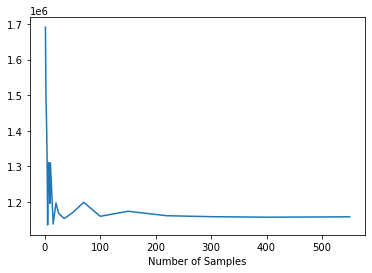

In [278]:
# converge_Series = 
pd.Series(data = test_vals*-1, index = num_sces).plot.line(
#         title = , 
    )

In [277]:
converge_Series.T.to_excel('converge_test_500samples.xlsx')

In [271]:
converge_Series.index.names = ['Number of Samples']

In [4]:
plot_labels = {
        'x': 'Number of Samples', 
        'y': 'Objective Value [Euro]'
#         **{str(col): f"CS {col}" for col in columns}, #'Number of CS-SS Connections',
#         
    }
fig = px.line(converge_Series, 
          x=converge_Series.index, 
          y=converge_Series, 
          title='Convergence of SAA',
          labels = plot_labels

     )

fig.show()

NameError: name 'px' is not defined

In [53]:
# Save solutions of all subscenario models to excel sheet. This can be very slow
csap_ef.write_tree_solution('efsol.xlsx')

ERROR: evaluating object as numeric value: '2'.calA[137,peak]
        (object: <class 'pyomo.core.base.param._ParamData'>)
ERROR: evaluating object as numeric value: '2'.w_cs2poi[178,94,peak]
        (object: <class 'pyomo.core.base.expression._GeneralExpressionData'>)


KeyboardInterrupt: 